# Model Output Notebook

<img style="float:center;" src="https://arcticexpansion.vse.gmu.edu/sites/arcticexpansion.vsnet.gmu.edu/files/images/header5d2.png" width=600px>

### ADCIRC-SWAN Output


### Initialize Libraries

In [1]:
import warnings;warnings.filterwarnings("ignore")
import netCDF4 as nc4;        import pandas as pd
import pathlib as pl;         import os
import numpy as np;           import xarray as xr
from scipy import sparse
from scipy.sparse.csgraph import connected_components
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from functools import partial
from scipy.signal import find_peaks
from scipy.sparse import coo_matrix

In [2]:
def compute_keep_idx(sample_path, min_depth, max_depth):
    ds0   = xr.open_dataset(sample_path, engine="netcdf4", mask_and_scale=False)
    depth = ds0.depth.values
    fv    = ds0.depth.encoding.get("_FillValue", None)
    mask  = np.ones_like(depth, dtype=bool)
    if fv is not None:
        mask &= (depth != fv)
    mask &= (depth >= min_depth)
    mask &= (depth <= max_depth)
    keep_idx = np.where(mask)[0]
    ds0.close()
    return keep_idx

# %%

def preprocess(ds, year, keep_idx=None):
    time = pd.to_datetime(ds.time.values)
    start, end = f"{year}-01-01", f"{year}-12-31T23:00:00"
    ds = ds.sel(time=slice(start, end))
    if keep_idx is not None:
        ds = ds.isel(node=keep_idx)
    return ds

# %%

def open_zeta_dataset(root_path, years, keep_idx, chunks):
    ds_list = []
    for year in years:
        path = pl.Path(root_path)/str(year)/"fort.63.cf.nc"
        ds   = xr.open_dataset(str(path), engine="netcdf4", mask_and_scale=True, decode_cf=True)
        ds   = preprocess(ds, year, keep_idx)
        ds   = ds.chunk(chunks)
        ds_list.append(ds)
    return xr.concat(ds_list, dim="time")

# %%

def build_adjacency(global_conn, keep_idx):
    mask_tri = np.all(np.isin(global_conn, keep_idx), axis=1)
    tri_filt = global_conn[mask_tri]
    local_map = {g:i for i,g in enumerate(keep_idx)}
    remap = np.vectorize(local_map.get)(tri_filt)
    row = np.hstack([remap[:,0],remap[:,1], remap[:,1],remap[:,2], remap[:,2],remap[:,0]])
    col = np.hstack([remap[:,1],remap[:,0], remap[:,2],remap[:,1], remap[:,0],remap[:,2]])
    data= np.ones_like(row, dtype=int)
    N = len(keep_idx)
    return sparse.coo_matrix((data,(row,col)), shape=(N,N)).tocsr()

# %%

In [3]:
root = '/scratch/tmiesse/project/data4spatial'
YEARS = range(1987,2025)
MIN_DEPTH, MAX_DEPTH = 0.0001, 3.0
sample = f"{root}/2023/fort.63.cf.nc"
keep_idx = compute_keep_idx(sample, MIN_DEPTH, MAX_DEPTH)
print(f"Keeping {len(keep_idx)} nodes")

global_conn = xr.open_dataset(sample, engine="netcdf4")["face_node_connectivity"].values - 1
adj = build_adjacency(global_conn, keep_idx)

Keeping 132111 nodes


In [4]:
sample_path = f"{root}/2023/fort.63.cf.nc"
global_conn = xr.open_dataset(sample_path, engine="netcdf4")["face_node_connectivity"].values - 1
adj         = build_adjacency(global_conn, keep_idx)

In [5]:
from dask.distributed import Client, LocalCluster
import math
n_workers   = int(os.environ.get("SLURM_NTASKS", "36"))
mem_per_cpu = os.environ.get("SLURM_MEM_PER_CPU", "12GB")

cluster = LocalCluster(
    n_workers=n_workers,
    threads_per_worker=1,
    processes=True,
    memory_limit=mem_per_cpu
)
client = Client(cluster)
print(client)
SPINUP_DAYS= 14
DROP_START = SPINUP_DAYS * 24

<Client: 'tcp://127.0.0.1:45291' processes=36 threads=36, memory=402.33 GiB>


2025-05-22 20:21:31,174 - distributed.nanny - WARNING - Restarting worker
2025-05-22 20:21:31,273 - distributed.nanny - WARNING - Restarting worker
2025-05-22 20:21:31,282 - distributed.nanny - WARNING - Restarting worker
2025-05-22 20:21:31,305 - distributed.nanny - WARNING - Restarting worker
2025-05-22 20:21:31,316 - distributed.nanny - WARNING - Restarting worker


In [6]:
SPINUP_HRS  = 14*24
def preprocess(ds):
    # 1) decode raw time → pandas
    ds = ds.assign_coords(time=pd.to_datetime(ds.time.values))
    # 2) drop anything outside that calendar year
    year = ds.time.dt.year.values[0]
    ds = ds.sel(time=slice(f"{year}-01-01", f"{year}-12-31"))
    # 3) drop the spin‑up
    ds = ds.isel(time=slice(SPINUP_HRS, None))
    # 4) subset to shallow nodes
    ds = ds.isel(node=keep_idx)
    return ds

In [7]:
paths = [str(pl.Path(root)/str(y)/"fort.63.cf.nc") for y in YEARS]
ds_all =  xr.open_mfdataset(
            paths,
            engine="netcdf4",            # <- use h5netcdf instead of netcdf4
            mask_and_scale=True,   # ← automatically turn fill‐values into NaN
            decode_cf=True,        # ← apply CF conventions (including _FillValue)
            preprocess=preprocess,
            combine="nested",
            concat_dim="time",
            chunks={'time':12})



times  = ds_all.time.values      # length T
z = ds_all.zeta.values
z = ds_all.zeta.values.astype(float)
#z[z < -99999.0] = np.nan

th1 = np.nanpercentile(z,  95.0, axis=0)
th2 = np.nanpercentile(z,  99.9, axis=0) 
client.close()
cluster.close()

2025-05-22 20:21:30,881 - distributed.worker - ERROR - Compute Failed
Key:       ('open_dataset-zeta-getitem-f8eee9c7e1a0779fc711505aab6f724a', 2, 0)
State:     executing
Task:  <Task ('open_dataset-zeta-getitem-f8eee9c7e1a0779fc711505aab6f724a', 2, 0) _execute_subgraph(...)>
Exception: "OSError(-101, 'NetCDF: HDF error')"
Traceback: '  File "/home/tmiesse/miniforge3/envs/general/lib/python3.12/site-packages/dask/array/core.py", line 133, in getter\n    c = np.asarray(c)\n        ^^^^^^^^^^^^^\n  File "/home/tmiesse/miniforge3/envs/general/lib/python3.12/site-packages/xarray/core/indexing.py", line 573, in __array__\n    return np.asarray(self.get_duck_array(), dtype=dtype, copy=copy)\n                      ^^^^^^^^^^^^^^^^^^^^^\n  File "/home/tmiesse/miniforge3/envs/general/lib/python3.12/site-packages/xarray/core/indexing.py", line 578, in get_duck_array\n    return self.array.get_duck_array()\n           ^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/home/tmiesse/miniforge3/envs/general/lib/

There are 1 HDF5 objects open!

Report: open objects on 72057594037927938


2025-05-22 20:21:31,248 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:33875
Traceback (most recent call last):
  File "/home/tmiesse/miniforge3/envs/general/lib/python3.12/site-packages/tornado/iostream.py", line 861, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/tmiesse/miniforge3/envs/general/lib/python3.12/site-packages/tornado/iostream.py", line 1116, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [Errno 104] Connection reset by peer

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/tmiesse/miniforge3/envs/general/lib/python3.12/site-packages/distributed/worker.py", line 2075, in gather_dep
    response = await get_data_from_worker(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/tmiesse/miniforge3/envs/general/

OSError: [Errno -101] NetCDF: HDF error: '/scratch/tmiesse/project/data4spatial/2003/fort.63.cf.nc'

In [10]:
client.close()
cluster.close()

In [32]:
# raw hourly surge → no rolling window
s1      = z           # shape = (T, N)
times_h = times       # shape = (T,)

# detect hourly peaks (≥ th2, min 24 h apart)
min_separation = 24
peaks = {}
for n in range(z.shape[1]):
    idx, _ = find_peaks(z[:,n], height=th2[n], distance=24)
    if idx.size:
        peaks[n] = idx
print(f"Found hourly peaks on {len(peaks)} nodes")

# build masks at the two thresholds
mask1 = s1 >= th1[None, :]    # 95th‐perc mask
mask2 = s1 >= th2[None, :]    # 99.9th‐perc mask

# extract hourly footprints
footprints = {}
for t in np.where(mask2.any(axis=1))[0]:
    nodes_t = np.nonzero(mask1[t])[0]
    sub     = adj[nodes_t][:, nodes_t]
    labels, _ = connected_components(sub, directed=False)
    full = -1 * np.ones(s1.shape[1], dtype=int)
    full[nodes_t] = labels
    footprints[t] = full

print(f"Extracted {len(footprints)} hourly footprints at times: {list(footprints.keys())}")


Found hourly peaks on 131274 nodes
Extracted 690 hourly footprints at times: [np.int64(22), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(48), np.int64(49), np.int64(51), np.int64(52), np.int64(53), np.int64(60), np.int64(71), np.int64(81), np.int64(82), np.int64(83), np.int64(84), np.int64(85), np.int64(86), np.int64(87), np.int64(88), np.int64(89), np.int64(90), np.int64(91), np.int64(92), np.int64(93), np.int64(98), np.int64(99), np.int64(100), np.int64(101), np.int64(102), np.int64(103), np.int64(104), np.int64(105), np.int64(106), np.int64(107), np.int64(108), np.int64(109), np.int64(110), np.int64(111), np.int64(112), np.int64(113), np.int64(114), np.int64(115), np.int64(116), np.int64(117), np.int64(118), np.int64(119), np.int64(120), np.int64(121), np.int64(130), np.int64(131), np.int64(147), np.int64(148), np.int64(149), np.int64(164), np.int64(165), np.int64(166), np.int64(167), np.int64(168), np.int64(169), np.int64(171), np.int64(175), np.int64(176), np.i

In [16]:
#def cluster_events(feature_matrix, n_clusters=8):
#    """PCA→KMeans clustering of your event footprints."""
#    scores = PCA(n_components=6).fit_transform(feature_matrix)
#    return KMeans(n_clusters=n_clusters, random_state=0).fit_predict(scores)
from sklearn.cluster import AgglomerativeClustering

def cluster_events(feature_matrix, n_clusters=8):
    """
    Deterministic clustering of event‐footprint PCA scores
    via agglomerative (hierarchical) clustering.
    """
    # 1) reduce dimensionality exactly as before
    scores = PCA(n_components=6).fit_transform(feature_matrix)
    # 2) do a purely deterministic clustering
    return AgglomerativeClustering(
        n_clusters=n_clusters,
        linkage="ward"          # or "average"/"complete" — all are deterministic
    ).fit_predict(scores)

In [18]:
event_idxs  = sorted(footprints.keys())      # the integer time‐indices of each event
event_times = times_h[event_idxs]            # the actual datetime for each event

# then build your feature matrix:
X = mask1[event_idxs].astype(int)
n_clusters = 8
labels = cluster_events(X, n_clusters=n_clusters)   # array length = n_events

In [19]:
ds_events = xr.Dataset(
    { "cluster": (("event",), labels) },
    coords={
        "event": ("event", np.arange(len(event_idxs))),
        "time":  ("event", event_times),
    }
)

In [20]:
foot_arr = np.stack([footprints[t] for t in event_idxs], axis=0)  

In [21]:
foot_da = xr.DataArray(
    foot_arr,
    dims=("event", "node"),
    coords={
        "event": ("event", event_idxs),
        "node":  ("node", keep_idx)
    },
    name="component"
)
ds_events = ds_events.assign(component=foot_da)
presence = (ds_events["component"] >= 0).astype(float)
avg_footprints = presence.groupby(ds_events["cluster"]).mean(dim="event")
counts = ds_events["cluster"].groupby(ds_events["cluster"]).count(dim="event")

In [22]:
# 1) Extract event times (from your ds_events) and hourly times, both as tz‑naive
ev_times     = pd.to_datetime(ds_events["time"].values).tz_localize(None)
hourly_times = pd.to_datetime(times_h).tz_localize(None)

# 2) Build the list of matching indices, catching any that fail
time_idx_list = []
missing        = []
for t in ev_times:
    try:
        idx = hourly_times.get_loc(t)
        time_idx_list.append(int(idx))
    except KeyError:
        missing.append(t)

# 3) Report
print(f"Events in ds_events   : {len(ev_times)}")
print(f"Footprints available  : {len(footprints)}")
print(f"Matched indices       : {len(time_idx_list)}")
if missing:
    print("Missing event times (no hourly match):")
    for t in missing:
        print("  ", t)
else:
    print("All event times matched successfully.")

Events in ds_events   : 690
Footprints available  : 690
Matched indices       : 690
All event times matched successfully.


In [23]:
comp_arr = np.stack([footprints[t] for t in time_idx_list], axis=0)
presence = (comp_arr >= 0).astype(int)
ecpn     = presence.sum(axis=0)

In [24]:


# 3) Assemble the summary Dataset
ds_summary = xr.Dataset(
    data_vars={
        # connected-component labels per event/node
        "component": (("event","node"), comp_arr.astype(int)),
        # cluster ID per event
        "cluster_event": (("event",), ds_events["cluster"].values.astype(int)),
        # time of each event
        "time": (("event",), ds_events["time"].values),
        # event‐count per node
        "event_count_per_node": (("node",), ecpn.astype(int)),
        # event‐count per cluster
        "event_count_per_cluster": (("cluster",), counts.values.astype(int)),
    },
    coords={
        "event": ("event", ds_events["event"].values),
        "node":  ("node",  ds_all["node"].values),
        "cluster":("cluster", counts.cluster.values),
        "x":     ("node",  ds_all["x"].values),
        "y":     ("node",  ds_all["y"].values),
    },
    attrs={
        "description": "Surge event summary: times, clusters, components, counts",
        "node_selection": f"depth {MIN_DEPTH}–{MAX_DEPTH} m",
        "spinup_hours": SPINUP_HRS,
    }
)
ds_summary.to_netcdf("/scratch/tmiesse/project/surge_cluster_summary_1hr.nc")

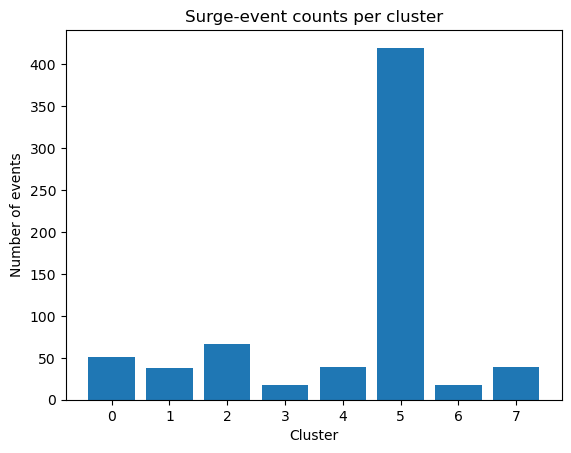

In [25]:
import matplotlib.pyplot as plt

plt.bar(counts["cluster"].values, counts.values)
plt.xlabel("Cluster")
plt.ylabel("Number of events")
plt.title("Surge‐event counts per cluster")
plt.show()

In [26]:
sample = pl.Path(root)/"2023"/"fort.63.cf.nc"
ds0    = xr.open_dataset(str(sample), engine="netcdf4", mask_and_scale=False)
x_all  = ds0.x.values                          # (n_nodes,)
y_all  = ds0.y.values                          # (n_nodes,)
# connectivity: drop time dim, zero‑base
conn0    = ds0.face_node_connectivity.values - 1  # now shape (nele, 3)
ds0.close()


In [27]:
import cartopy.crs as ccrs;   import cartopy.io.img_tiles as cart_img
import cartopy as cart;       import cartopy.io.img_tiles as cimgt
import matplotlib.pyplot as plt
import matplotlib.tri as mtri

In [28]:
import matplotlib.tri as mtri
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm

# 0) Prepare your event‑count array (length = n_all_nodes)
#    ecpn is the per‑node event counts you computed earlier (len = n_kept)
event_counts = np.zeros_like(x_all, dtype=int)
event_counts[keep_idx] = ecpn  # shallow nodes get their counts, others stay 0

# how many distinct categories?
min_c, max_c = event_counts.min(), event_counts.max()
levels = np.arange(min_c, max_c + 2) - 0.5   # e.g. [-0.5,0.5,1.5,...,max+0.5]
n_cats = max_c - min_c + 1

# choose a discrete colormap

In [29]:
min_c, max_c = 0, 100#event_counts.max()
levels = np.arange(min_c, max_c + 2) - 0.5
cmap   = plt.get_cmap("jet", max_c - min_c + 1)
norm   = BoundaryNorm(boundaries=levels, ncolors=cmap.N)

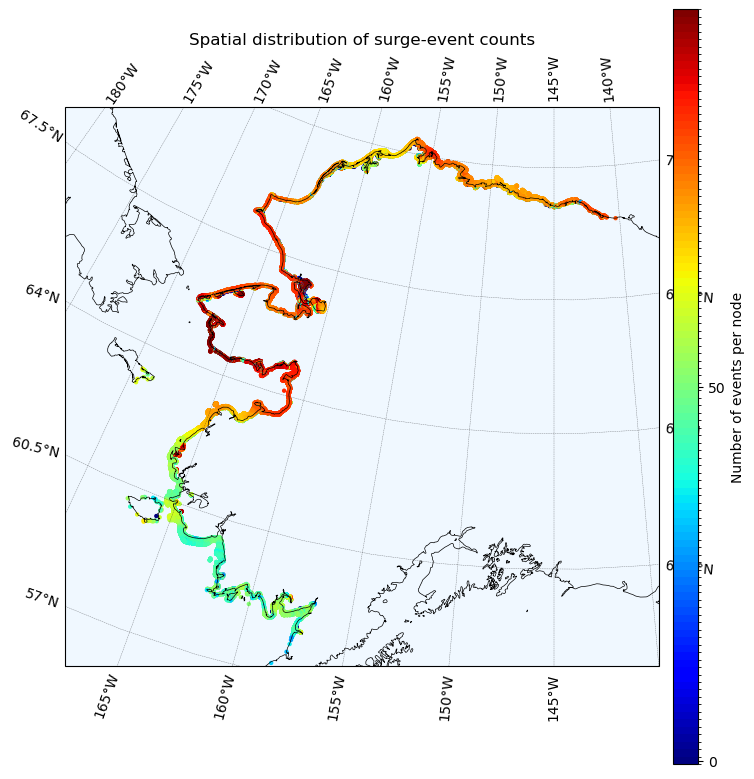

In [30]:



# 1) Triangulation (reuse your elements array)
#tri = mtri.Triangulation(x_all, y_all, triangles=conn0)

# 2) Make the map
lat1, lat2 = 58, 71
lon1, lon2 = -169, -140

fig = plt.figure(figsize=(8, 8))
ax  = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-145))
ax.set_extent([lon1, lon2, lat1, lat2], ccrs.PlateCarree())

# base layers
ax.add_feature(cfeature.LAND,  facecolor="lightgray")
ax.add_feature(cfeature.OCEAN, facecolor="aliceblue")
ax.coastlines(resolution="10m", linewidth=0.5)

# gridlines
gl = ax.gridlines(xlocs=np.arange(-190, -100, 5),
                  ylocs=np.arange(  50,   90, 3.5),
                  draw_labels=True, linewidth=0.3, color="black", alpha=0.5,
                  y_inline=False, linestyle="--")
gl.xlabels_top    = False
gl.ylabels_left   = False
gl.xformatter     = ccrs.cartopy.mpl.gridliner.LONGITUDE_FORMATTER

# 3) Plot the counts
sc = ax.scatter(
    x_all[keep_idx],
    y_all[keep_idx],
    c=event_counts[keep_idx],
    cmap=cmap,
    norm=norm,
    s=10,
    transform=ccrs.PlateCarree(),
    edgecolors="none"
)
# 4) Colorbar with integer ticks
cbar = plt.colorbar(
    sc, ax=ax,
    boundaries=levels,
    ticks=np.arange(min_c, max_c,50),
    pad=0.02,
    aspect=30
)
cbar.set_label("Number of events per node")

plt.title("Spatial distribution of surge‐event counts")
plt.tight_layout()
plt.show()